In our previous discussion, we found that the long query sequence will greatly reduce the uniqueness of the matching sequence in the database. It is crucial to reduce the search space. In our data collected in the second round, we have used GPS to restrict the searching span and used compass to produce a "maglock" effect, which ceased to detect the magnetic field when the compass was not facing the same direction w.r.t. the door.

In [1]:
import api as magtraceapi
import numpy as np
import matplotlib.pyplot as plt
import analysistools as tools
from tqdm import tqdm
import re
import scipy.signal as signal

In [2]:
api = magtraceapi.MagRetraceDataAPI("data")

In [3]:
api.list_template_titles()

Available template titles:
  0 - cb_g_exit_entering_template_2023324_1557
  1 - cb_g_exit_entering_template_2023327_1214
  2 - cb_g_exit_entering_template_2023328_1631
  3 - cb_g_exit_entering_template_45_deg_holding_2023327_1219
  4 - cb_g_exit_entering_template_in_pocket_2023327_1215
  5 - cb_g_exit_exiting_template_2023327_1216
  6 - cb_g_exit_template_1_2023322_1146
  7 - cb_g_exit_template_2023322_1344
  8 - cb_g_exit_template_2_2023322_1147
  9 - cb_g_exit_template_2_2023322_1344
  10 - cb_g_exit_template_3_2023322_1148
  11 - cb_g_template_short_2023331_1941
  12 - cb_lg_exit_entering_template_2023327_1221
  13 - cb_lg_exit_template_2023323_1225
  14 - composite_bldg_lg_exit_template_2023323_1226
  15 - hw_3f_door_template_maglocked_202341_2018
  16 - mwt_reddoor_template_maglocked_202341_1941
  17 - su_canteen_entrance_template_2023327_1223


In [4]:
api.list_traversal_titles()

Available traversal titles:
  0 - aexit_to_hw_traversal_maglocked_2023331_2015
  1 - bonham_to_cross_cafe_2023322_1206
  2 - bonham_to_hku_campus_2023322_1256
  3 - cb_1f_traversal_maglocked_2023331_1952
  4 - cb_2f_traversal_maglocked_2023331_1954
  5 - cb_3f_traversal_maglocked_2023331_1957
  6 - cb_4f_traversal_maglocked_2023331_2003
  7 - cb_5f_traversal_maglocked_2023331_2005
  8 - cb_cbc_takecourse_2023321_1715
  9 - cb_elevator_static_maglocked_2023331_2008
  10 - cb_g_traversal_maglocked_2023331_1945
  11 - cb_lg_traversal_maglocked_2023331_1949
  12 - cb_traversal_g_in_lg_out_2023324_1559
  13 - cbc_inner_traversal_2023322_1145
  14 - composite_bldg_traversal_maglocked_2023331_2011
  15 - cpd_garden_traversal1_maglocked_2023331_1937
  16 - cpd_garden_traversal2_maglocked_2023331_1940
  17 - cym_1f_traversal_maglocked_202341_2008
  18 - cym_2f_traversal_maglocked_202341_2004
  19 - cym_3f_traversal_maglocked_202341_2002
  20 - cym_4f_traversal_maglocked_202341_1955
  21 - cym_5

In [52]:
# First study: The CB G entrance.
template = api.get_template_data("cb_g_template_short_2023331_1941")
# We need data from Chow Yei Ching bldg and composite bldg and cpd garden, since they are very close!
maglocked_traversals = []
maglocked_traversals += api.get_traversal_data_by_keywords(["maglocked", "cb"])
maglocked_traversals += api.get_traversal_data_by_keywords(["maglocked", "composite"])
maglocked_traversals += api.get_traversal_data_by_keywords(["maglocked", "cpd_garden"])
for mt in maglocked_traversals:
    print(mt["title"])

cb_1f_traversal_maglocked_2023331_1952
cb_2f_traversal_maglocked_2023331_1954
cb_3f_traversal_maglocked_2023331_1957
cb_4f_traversal_maglocked_2023331_2003
cb_5f_traversal_maglocked_2023331_2005
cb_elevator_static_maglocked_2023331_2008
cb_g_traversal_maglocked_2023331_1945
cb_lg_traversal_maglocked_2023331_1949
composite_bldg_traversal_maglocked_2023331_2011
cpd_garden_traversal1_maglocked_2023331_1937
cpd_garden_traversal2_maglocked_2023331_1940


In [53]:
len(maglocked_traversals)

11

cb_1f_traversal_maglocked_2023331_1952
Sampling rate:  100.43185550231166 Hz


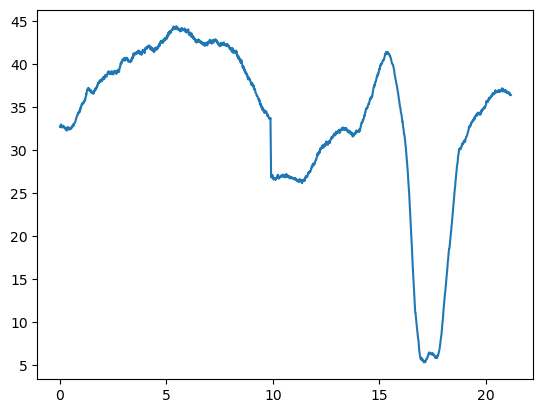

In [54]:
# Inspect the data structure.
sample = maglocked_traversals[0]
sample_title, sample_data = sample["title"], sample["data"]
print(sample_title)
timeseq, sig = sample_data.time_seq, sample_data.mag_abs
plt.plot(timeseq, sig)
sampling_rate = 1 / (timeseq[1] - timeseq[0])
print("Sampling rate: ", sampling_rate, "Hz")

In [55]:
# We set the approximate sampling rate to 100 Hz.
fs = 100

The data at the time of our exploration is 11. How about we plot a grid of the data in 12?

11it [00:12,  1.16s/it]


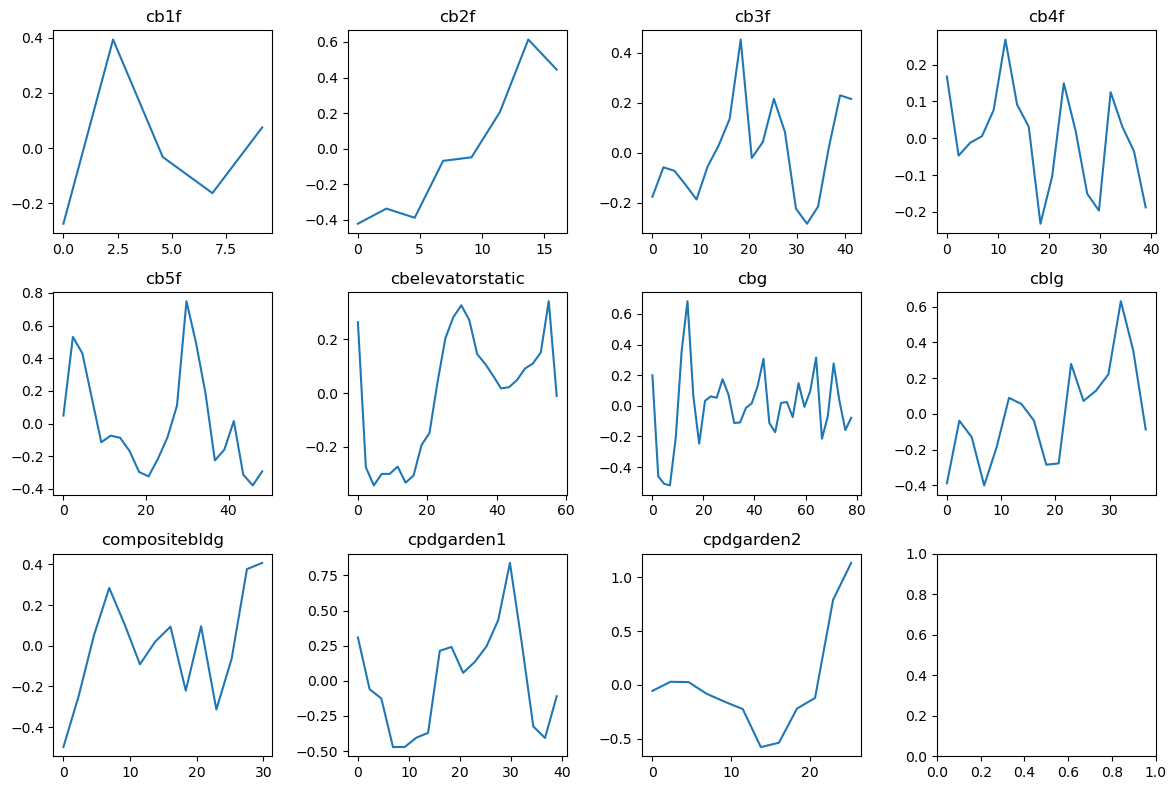

In [56]:
fig, axs = plt.subplots(3, 4, figsize=(12, 8))
template_length = template.time_seq.shape[0]
for idx, mt in tqdm(enumerate(maglocked_traversals)):
    mt_title = mt["title"]
    mt_data = mt["data"]
    ax = axs[idx // 4, idx % 4]
    timeseq, ds = tools.get_dtw_distance(template, mt_data, analysis_target='abs', 
                                         downsampling_coefficient=10, windowing_coefficient=1.1)
    # DS amplitude normalization
    ds = ds - np.mean(ds)
    ds = ds / template_length
    ax.plot(timeseq, ds)
    mt_title = re.sub(r"_\d{6,}_\d{4}", "", mt_title)
    mt_title = mt_title.replace("_", "")\
                          .replace("maglocked", "")\
                            .replace("traversal", "")
    ax.title.set_text(mt_title)
fig.tight_layout()

In [46]:
# We also plot the features of other experiments.
# The MWT experiment.
template = api.get_template_data("mwt_reddoor_template_maglocked_202341_1941")

maglocked_traversals = []
maglocked_traversals += api.get_traversal_data_by_keywords(["maglocked", "cym"])
for mt in maglocked_traversals:
    print(mt["title"])

cym_1f_traversal_maglocked_202341_2008
cym_2f_traversal_maglocked_202341_2004
cym_3f_traversal_maglocked_202341_2002
cym_4f_traversal_maglocked_202341_1955
cym_5f_to_mwt_maglocked_202341_1939
cym_5f_via_escalator_mwt_crossreddoor_41s_maglocked_202341_1946


6it [00:03,  1.80it/s]


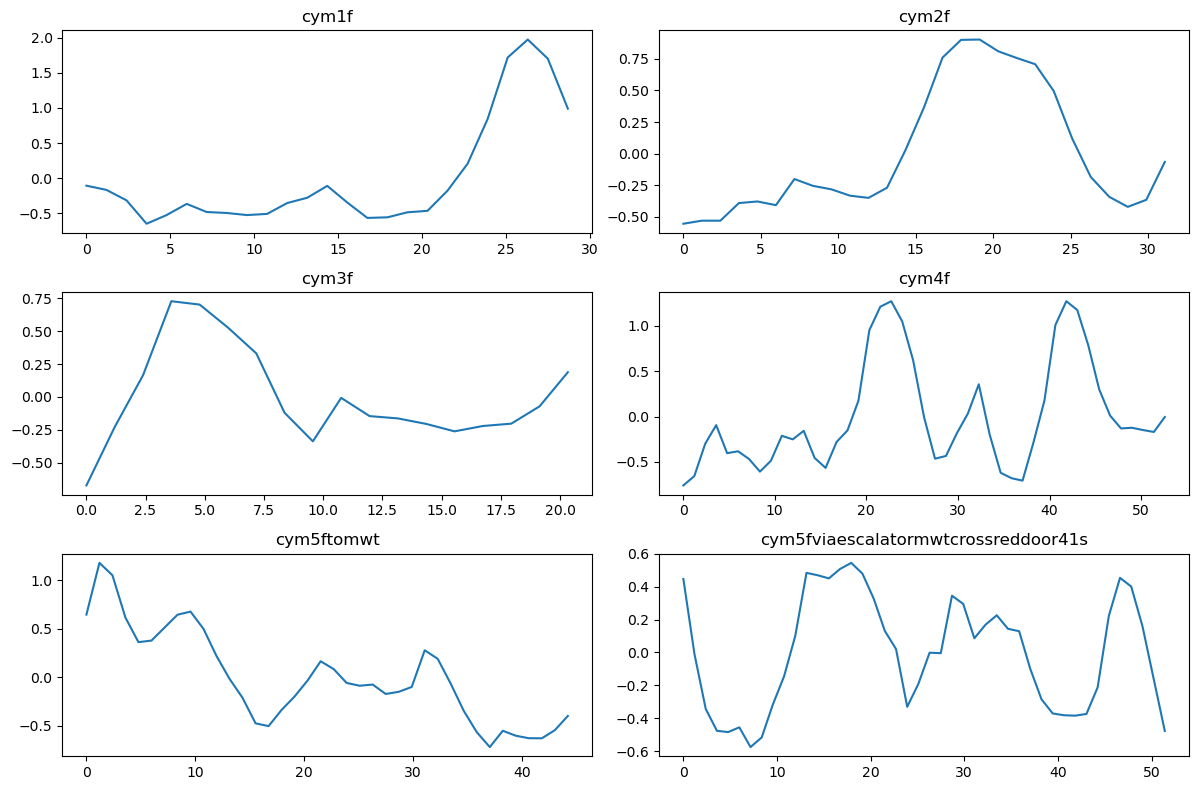

In [48]:
fig, axs = plt.subplots(3, 2, figsize=(12, 8))
template_length = template.time_seq.shape[0]
for idx, mt in tqdm(enumerate(maglocked_traversals)):
    mt_title = mt["title"]
    mt_data = mt["data"]
    ax = axs[idx // 2, idx % 2]
    timeseq, ds = tools.get_dtw_distance(template, mt_data, analysis_target='abs', 
                                         downsampling_coefficient=10, windowing_coefficient=1.1)
    # DS amplitude normalization
    ds = ds - np.mean(ds)
    ds = ds / template_length
    ax.plot(timeseq, ds)
    mt_title = re.sub(r"_\d{6,}_\d{4}", "", mt_title)
    mt_title = mt_title.replace("_", "")\
                          .replace("maglocked", "")\
                            .replace("traversal", "")
    ax.title.set_text(mt_title)
fig.tight_layout()

In [49]:
# The HW experiment.
template = api.get_template_data("hw_3f_door_template_maglocked_202341_2018")

maglocked_traversals = []
maglocked_traversals += api.get_traversal_data_by_keywords(["maglocked", "hw"])
maglocked_traversals += api.get_traversal_data_by_keywords(["maglocked", "composite"])
for mt in maglocked_traversals:
    print(mt["title"])

aexit_to_hw_traversal_maglocked_2023331_2015
hw_1f_traversal_maglocked_202341_2030
hw_2f_traversal_maglocked_202341_2026
hw_3f_traversal_enter_at_8s_maglocked_202341_2021
hw_4f_su_backdoor_traversal_maglocked_202341_2036
hw_elevator_traversal_maglocked_202341_2033
composite_bldg_traversal_maglocked_2023331_2011


7it [00:08,  1.24s/it]


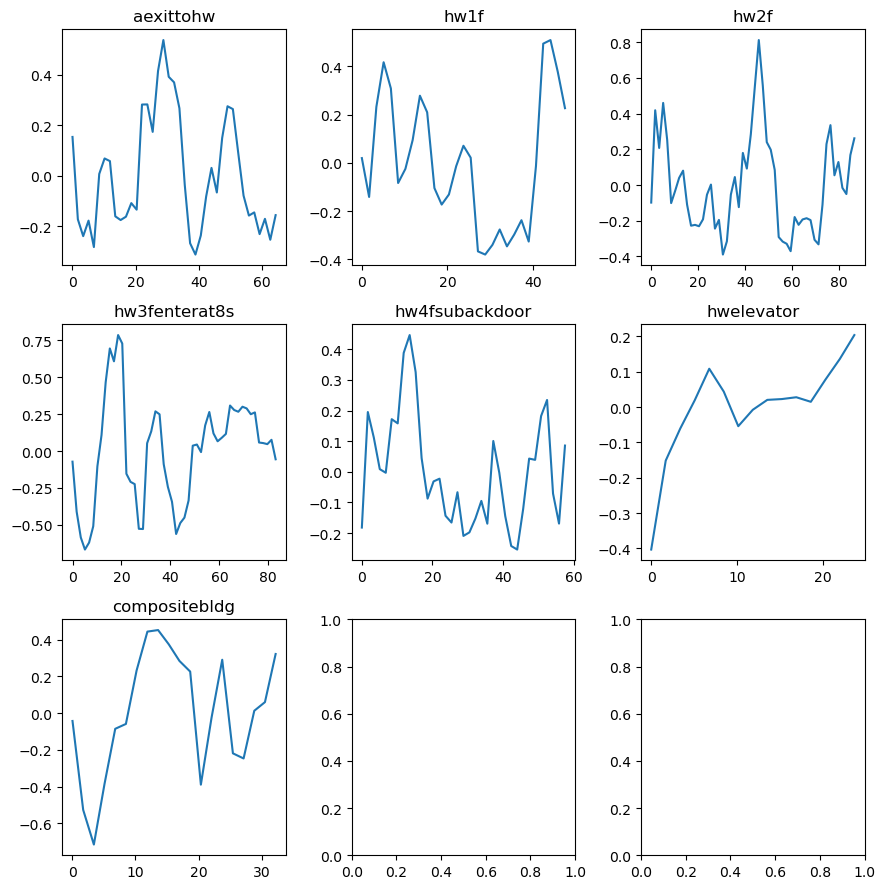

In [51]:
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
template_length = template.time_seq.shape[0]
for idx, mt in tqdm(enumerate(maglocked_traversals)):
    mt_title = mt["title"]
    mt_data = mt["data"]
    ax = axs[idx // 3, idx % 3]
    timeseq, ds = tools.get_dtw_distance(template, mt_data, analysis_target='abs', 
                                         downsampling_coefficient=10, windowing_coefficient=1.1)
    # DS amplitude normalization
    ds = ds - np.mean(ds)
    ds = ds / template_length
    ax.plot(timeseq, ds)
    mt_title = re.sub(r"_\d{6,}_\d{4}", "", mt_title)
    mt_title = mt_title.replace("_", "")\
                          .replace("maglocked", "")\
                            .replace("traversal", "")
    ax.title.set_text(mt_title)
fig.tight_layout()

## Probable Feature: The Prominence

In [60]:
# Let's carry out some prominence analysis.
distance_signals = []
for idx, mt in tqdm(enumerate(maglocked_traversals)):
    mt_title = mt["title"]
    mt_data = mt["data"]
    timeseq, ds = tools.get_dtw_distance(template, mt_data, analysis_target='abs', 
                                         downsampling_coefficient=10, windowing_coefficient=1.3,
                                         step_coefficient=0.25,
                                         perform_gaussian_filtering=False, gaussian_filter_sigma=0.5)
    # DS amplitude normalization
    ds = ds - np.mean(ds)
    distance_signals.append(ds)

12it [00:16,  1.40s/it]


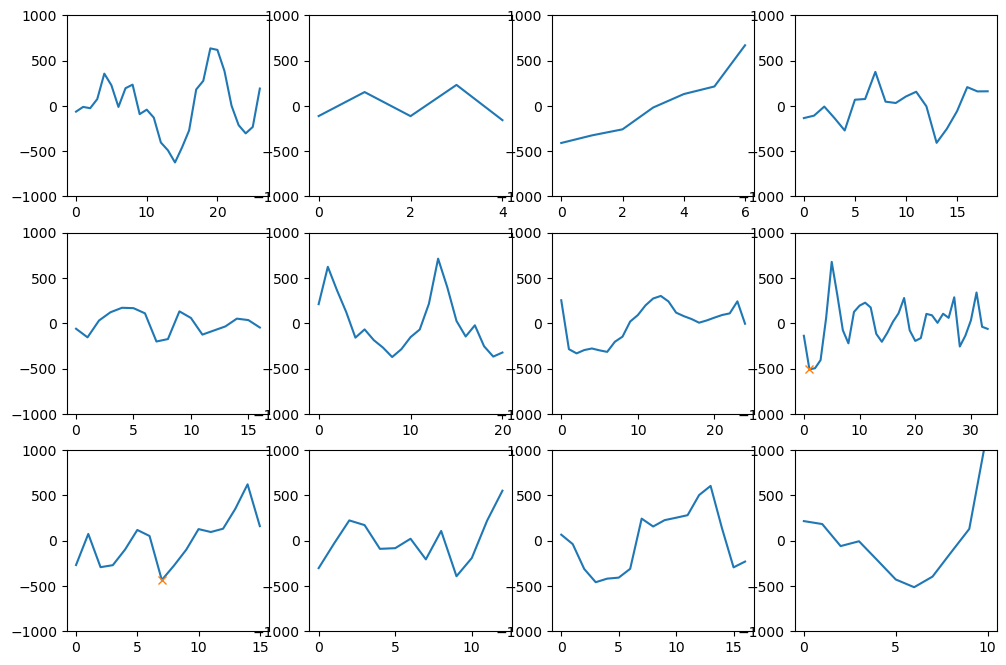

In [64]:
fig, axs = plt.subplots(3, 4, figsize=(12, 8))
for ds_idx in range(len(distance_signals)):
    # Setup peak finding algorithms.
    """
    Properties of peaks:
    - Prominence: The prominence of a peak measures how much a peak stands out from the surrounding baseline of the signal 
        and is defined as the vertical distance between the peak and its lowest contour line.
    - Width: The width of a peak is defined as the horizontal distance between its rising and falling slope at a chosen height.
    - Height: The height of a peak is defined as the vertical distance between the peak and the baseline.
    - wlen: A window length in samples that optionally limits the evaluated area for each peak to a subset of x.
    """
    ax = axs[ds_idx // 4, ds_idx % 4]
    ds = distance_signals[ds_idx]
    amp_reversed_ds = -ds
    peak, _ = signal.find_peaks(amp_reversed_ds, 
                                height=400,
                                width=(0, 5),
                                rel_height=1)
    ax.plot(ds)
    ax.set_ylim(-1000, 1000)
    ax.plot(peak, ds[peak], "x")

X analysis


12it [00:17,  1.44s/it]


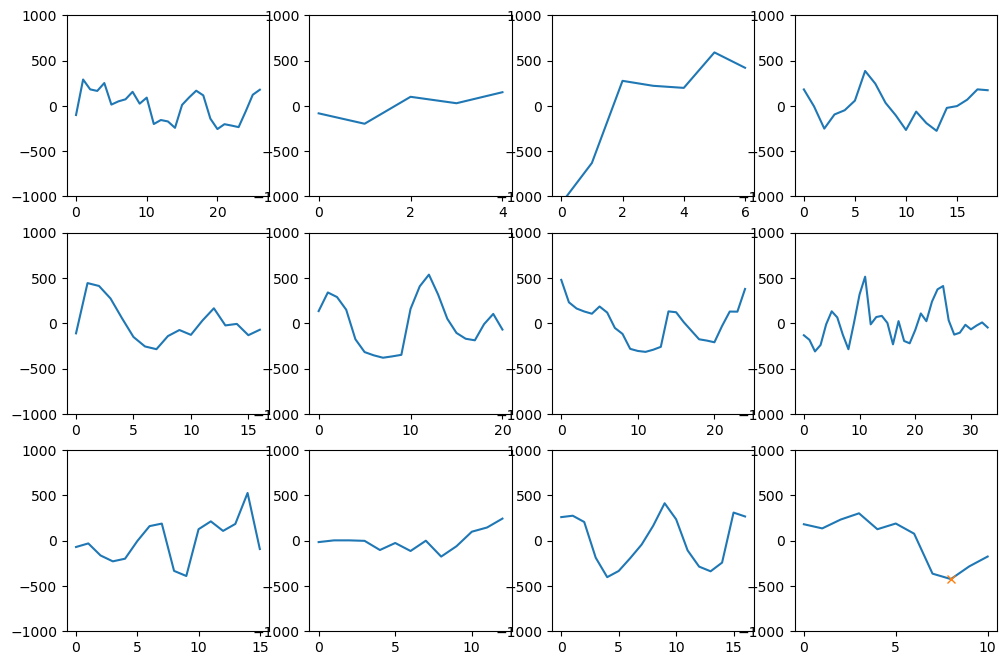

In [70]:
# Think more... Given this scenario, can we calibrate more on x, y, z data to see something special matches?
print("X analysis")
x_distance_signals = []
for idx, mt in tqdm(enumerate(maglocked_traversals)):
    mt_title = mt["title"]
    mt_data = mt["data"]
    timeseq, ds = tools.get_dtw_distance(template, mt_data, analysis_target='x', 
                                         downsampling_coefficient=10, windowing_coefficient=1.3,
                                         step_coefficient=0.25,
                                         perform_gaussian_filtering=False, gaussian_filter_sigma=0.5)
    # DS amplitude normalization
    ds = ds - np.mean(ds)
    x_distance_signals.append(ds)

fig, axs = plt.subplots(3, 4, figsize=(12, 8))
for ds_idx in range(len(x_distance_signals)):
    # Setup peak finding algorithms.
    """
    Properties of peaks:
    - Prominence: The prominence of a peak measures how much a peak stands out from the surrounding baseline of the signal 
        and is defined as the vertical distance between the peak and its lowest contour line.
    - Width: The width of a peak is defined as the horizontal distance between its rising and falling slope at a chosen height.
    - Height: The height of a peak is defined as the vertical distance between the peak and the baseline.
    - wlen: A window length in samples that optionally limits the evaluated area for each peak to a subset of x.
    """
    ax = axs[ds_idx // 4, ds_idx % 4]
    ds = x_distance_signals[ds_idx]
    amp_reversed_ds = -ds
    peak, _ = signal.find_peaks(amp_reversed_ds, 
                                height=400,
                                width=(0, 5),
                                rel_height=1)
    ax.plot(ds)
    ax.set_ylim(-1000, 1000)
    ax.plot(peak, ds[peak], "x")

Y analysis


12it [00:17,  1.43s/it]


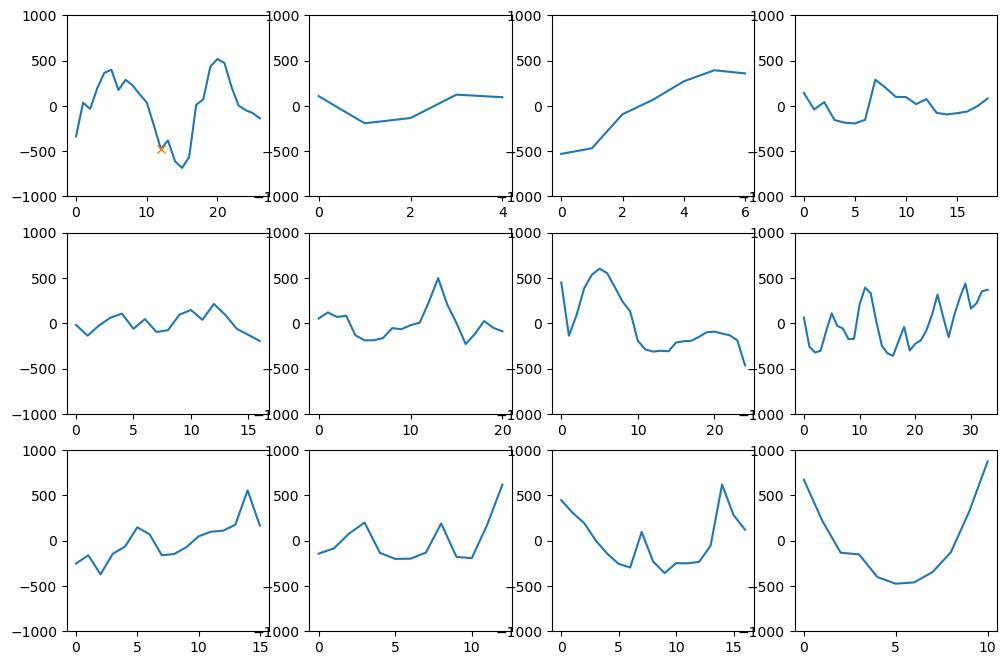

In [69]:
# Think more... Given this scenario, can we calibrate more on x, y, z data to see something special matches?
print("Y analysis")
y_distance_signals = []
for idx, mt in tqdm(enumerate(maglocked_traversals)):
    mt_title = mt["title"]
    mt_data = mt["data"]
    timeseq, ds = tools.get_dtw_distance(template, mt_data, analysis_target='y', 
                                         downsampling_coefficient=10, windowing_coefficient=1.3,
                                         step_coefficient=0.25,
                                         perform_gaussian_filtering=False, gaussian_filter_sigma=0.5)
    # DS amplitude normalization
    ds = ds - np.mean(ds)
    y_distance_signals.append(ds)


fig, axs = plt.subplots(3, 4, figsize=(12, 8))
for ds_idx in range(len(y_distance_signals)):
    # Setup peak finding algorithms.
    """
    Properties of peaks:
    - Prominence: The prominence of a peak measures how much a peak stands out from the surrounding baseline of the signal 
        and is defined as the vertical distance between the peak and its lowest contour line.
    - Width: The width of a peak is defined as the horizontal distance between its rising and falling slope at a chosen height.
    - Height: The height of a peak is defined as the vertical distance between the peak and the baseline.
    - wlen: A window length in samples that optionally limits the evaluated area for each peak to a subset of x.
    """
    ax = axs[ds_idx // 4, ds_idx % 4]
    ds = y_distance_signals[ds_idx]
    amp_reversed_ds = -ds
    peak, _ = signal.find_peaks(amp_reversed_ds, 
                                height=400,
                                width=(0, 5),
                                rel_height=1)
    ax.plot(ds)
    ax.set_ylim(-1000, 1000)
    ax.plot(peak, ds[peak], "x")

Z analysis


12it [00:18,  1.56s/it]


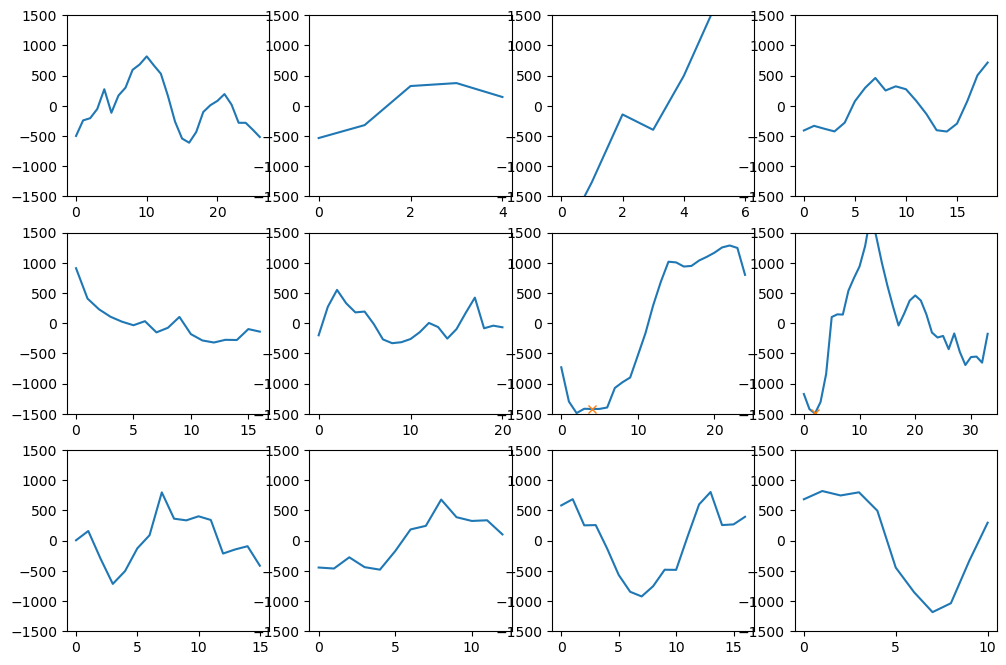

In [73]:
# Think more... Given this scenario, can we calibrate more on x, y, z data to see something special matches?
print("Z analysis")
z_distance_signals = []
for idx, mt in tqdm(enumerate(maglocked_traversals)):
    mt_title = mt["title"]
    mt_data = mt["data"]
    timeseq, ds = tools.get_dtw_distance(template, mt_data, analysis_target='z', 
                                         downsampling_coefficient=10, windowing_coefficient=1.3,
                                         step_coefficient=0.25,
                                         perform_gaussian_filtering=False, gaussian_filter_sigma=0.5)
    # DS amplitude normalization
    ds = ds - np.mean(ds)
    z_distance_signals.append(ds)


fig, axs = plt.subplots(3, 4, figsize=(12, 8))
for ds_idx in range(len(z_distance_signals)):
    # Setup peak finding algorithms.
    """
    Properties of peaks:
    - Prominence: The prominence of a peak measures how much a peak stands out from the surrounding baseline of the signal 
        and is defined as the vertical distance between the peak and its lowest contour line.
    - Width: The width of a peak is defined as the horizontal distance between its rising and falling slope at a chosen height.
    - Height: The height of a peak is defined as the vertical distance between the peak and the baseline.
    - wlen: A window length in samples that optionally limits the evaluated area for each peak to a subset of x.
    """
    ax = axs[ds_idx // 4, ds_idx % 4]
    ds = z_distance_signals[ds_idx]
    amp_reversed_ds = -ds
    peak, _ = signal.find_peaks(amp_reversed_ds, 
                                height=1000,
                                width=(0, 5),
                                rel_height=1)
    ax.plot(ds)
    ax.set_ylim(-1500, 1500)
    ax.plot(peak, ds[peak], "x")